# Part 4 - Query Parcels

### Parcel Feature Relationships and Querying

This notebook demonstrates the following:

1. How to query a feature layer
2. How to find parcel features within a parcel record.
3. How to find parcel features by an attribute.
4. Build up a dict of parcel features for Parcel Fabric capabilities.

#### Records
A Parcel Fabric contains a Records which represents the legal document information about a parcel or set of parcels.  The geometry of a record is the outer boundary of any parcel polygon features associated with a particular record.  The record feature and parcel feature(s) are related by GUID fields (GlobalID) in each.

<table style='float:left'><thead><th>Field Name</th><th>Type</th></thead><tbody><tr><td>GlobalID</td><td>GUID</td></tr></tbody>

#### Parcel features
A parcel type consists of a pair of feature classes.  
- A polygon feature class representing the area of a parcel.
- A COGO enabled line feature class representing the boundary of a parcel.

Parcel features (both lines and polygons) relate to a Record and to themselves:

<table style='float:left'><thead><th>Field Name</th><th>Type</th></thead><tbody><tr><td>CreatedByRecord</td><td>GUID</td></tr><tr><td>RetiredByRecord</td><td>GUID</td></tr></tbody>

In [1]:
from arcgis.gis import GIS
from arcgis.features.layer import FeatureLayerCollection
from arcgis.features.layer import FeatureLayer

In [2]:
base_server_url = "https://myserver.domain.com/web_adaptor/rest/services/WashingtonCountyLSA/"
gis = GIS("https://myserver.domain.com/portal/", "username", "pass.word", verify_cert=False)

# generate the enpoint urls for feature server, version management and parcel fabric
service_endpoints = ["FeatureServer", "VersionManagementServer"]                    
service_urls = {url: base_server_url + url for url in service_endpoints}

parcel_fabric_flc = FeatureLayerCollection(service_urls["FeatureServer"], gis)

In [23]:
# Get the URL of the Records feature layer
records_fl_url = [n for n in parcel_fabric_flc.layers if n.properties.name == "Records"]
records_fl_url = records_fl_url[0].url
records_fl_url

https://myserver.domain.com/web_adaptor/rest/services/WashingtonCountyLSA/FeatureServer/1


#### Find a parcel record by its name

- Access the Records feature layer
- Create a WHERE clause and list of fields to return
- Query the records feature layer
- Return the result as a spatial data frame
 

In [4]:
record_name = "Record001"         # name to search
out_fields = ["name", "globalId"] # fields to return

where = f"name = '{record_name}'"

records_fl = FeatureLayer(records_fl_url, gis)
record_row = records_fl.query(
    where=where,
    out_fields=out_fields,
).sdf

record_row

,OBJECTID,Name,GlobalID,SHAPE
0,123,Record001,{4B753DC5-AEDD-4703-AE56-B236EBB5DEFB},"{""rings"": [[[2474616.7778283805, 503108.655806..."


### Find parcel features by Record GlobalID
In the cell above, the Records feature layer was queried by using its name.  The GlobalID value for 'Record001' is now available to use in a search for its associated parcel features.

The proceeding cells will show the following:
1. Extract the globalID of the record
2. Access the parcel polygon feature layer
3. Query the features in the parcels feature layer associated to the record

`parcels(CreatedByRecord) = records(GlobalID)`

4. Draw the subset on a map

In [5]:
record_globalid = record_row.at[0, "GlobalID"]
record_globalid

'{4B753DC5-AEDD-4703-AE56-B236EBB5DEFB}'

In [22]:
# Get the URL of the parcel polygon feature layer
parcels_fl_url = [n for n in parcel_fabric_flc.layers if n.properties.name == "Tax_PF"]
parcels_fl_url = parcels_fl_url[0].url
parcels_fl_url

https://myserver.domain.com/web_adaptor/rest/services/WashingtonCountyLSA/FeatureServer/15


In [7]:
out_fields = ["name", "globalId"]
where_clause = f"CreatedByRecord = '{record_globalid}'"
parcels_fl = FeatureLayer(parcels_fl_url, gis)

parcels_subset = parcels_fl.query(where=where_clause, out_fields=out_fields)
parcels_subset

<FeatureSet> 12 features

In [18]:
from arcgis.widgets import MapView

map = gis.map('USA', zoomlevel=16)
map.draw(parcels_subset)
map.zoom_to_layer(parcels_subset)


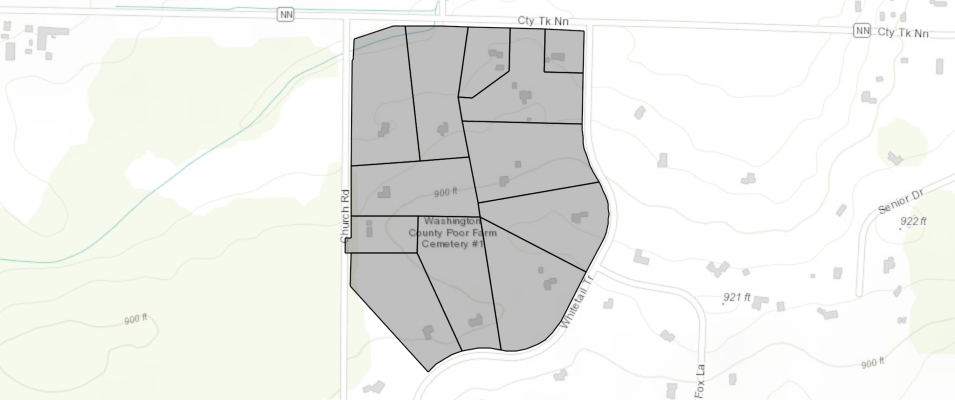

In [17]:
map.take_screenshot()

### API Ref Documentation

- [ArcGIS Python API - Version Manager](https://developers.arcgis.com/python/api-reference/arcgis.features.managers.html#versionmanager)
- [ArcGIS Python API - Parcel Fabric Manager](https://developers.arcgis.com/python/api-reference/arcgis.features.managers.html#parcelfabricmanager)
- [ArcGIS REST API - VersionManagementServer](https://developers.arcgis.com/rest/services-reference/enterprise/version-management-service.htm)
- [ArcGIS REST API - ParcelFabricServer](https://developers.arcgis.com/rest/services-reference/enterprise/overview-of-parcel-fabric-sevices.htm)
- [ArcGIS Pro - Branch Versioning Scenarios](https://pro.arcgis.com/en/pro-app/latest/help/data/geodatabases/overview/branch-version-scenarios.htm)